In [102]:
# load libaries
import sys
import os
from dotenv import dotenv_values
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import rasterio as rio
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping

%matplotlib inline

# append module path to path
sys.path.append('/Users/chasedawson/dev/landsat8_api')

import landsat8_api
import importlib; importlib.reload(landsat8_api)
from landsat8_api import Landsat8_API_Accessor

# remove module path from path
sys.path.pop()

# print cwd
os.getcwd()

'/Users/chasedawson/dev/uva_equity_center/summer-sandbox/landsat8'

In [103]:
# read in cville spatial data 
cville_sp = {}
for sp in ['counties', 'tracts', 'blkgps', 'blocks']:
    gdf = gpd.read_file('../spatial_units/data/cville_{sp}.shp'.format(sp = sp))
    gdf = gdf[gdf.COUNTYFP == "540"]
    cville_sp[sp] = gdf

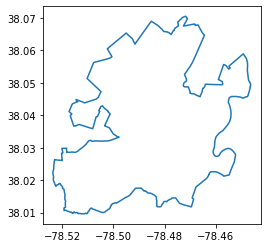

In [104]:
cville = gpd.read_file('../spatial_units/data/cville_counties.shp')
cville = cville[cville.COUNTYFP == "540"]
cville.boundary.plot()
plt.show()

In [105]:
# cville.geometry.convex_hull.to_file('cville_city_hull.shp')

In [106]:
config = dotenv_values('.env')
accessor = Landsat8_API_Accessor(config['USGS_USERNAME'], config['USGS_PASSWORD'])

Login Successful




In [96]:
cville_bounds = accessor.get_bounds(cville)

In [97]:
SEARCH_START = "2013-06-00"
SEARCH_END = "2021-08-06"

In [107]:
cville_scenes = accessor.search_scenes(cville_bounds, SEARCH_START, SEARCH_END)
cville_scene_metadata = accessor.get_scene_metadata(cville_scenes)

Searching Scenes...
Found 23 Scene(s).


/Users/chasedawson/dev/landsat8_api/landsat8_api.py:301: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf = gpd.GeoDataFrame(scene_metadata, crs='EPSG:4326')


In [108]:
cville_scene_metadata.iloc[0]['Start Time']

'2021:204:15:52:21.1375120'

In [53]:
os.chdir('/Users/chasedawson/dev/uva_equity_center/summer-sandbox/landsat8')

In [56]:
base_path = '../../climate_equity/bulk_orders/Bulk Order cville summer all/Landsat 8 OLI_TIRS C2 L2/'

In [99]:
folders = [
    'LC08_L2SP_016033_20170813_20200903_02_T1',
    'LC08_L2SP_016033_20180629_20200831_02_T1',
    'LC08_L2SP_016034_20140618_20200911_02_T1',
    'LC08_L2SP_016034_20140704_20200911_02_T1',
    'LC08_L2SP_016034_20140922_20200910_02_T1',
    'LC08_L2SP_016034_20150707_20200909_02_T1',
    'LC08_L2SP_016034_20160826_20200906_02_T1',
    'LC08_L2SP_016034_20170610_20201015_02_T1',
    'LC08_L2SP_016034_20170930_20200903_02_T1',
    'LC08_L2SP_016034_20190702_20200827_02_T1',
    'LC08_L2SP_016034_20190920_20200826_02_T1',
    'LC08_L2SP_016034_20200720_20210330_02_T1',
    'LC08_L2SP_016034_20200906_20200918_02_T1',
    'LC08_L2SP_016033_20210723_20210729_02_T1',
    'LC08_L2SP_016034_20200704_20200913_02_T1',
    'LC08_L2SP_016034_20210605_20210614_02_T1',
    'LC08_L2SP_016034_20200922_20201005_02_T1'
]

In [100]:
# open rasters and clip to cville city
for folder in folders:
    path = os.path.join(base_path, folder, folder + "_ST_B10.TIF")
    full_boundary = None
    with rio.open(path) as src:
        full_boundary = cville.to_crs(src.crs)
    raster_data = rxr.open_rasterio(path, masked=True).squeeze()
    raster_clipped = raster_data.rio.clip(full_boundary.geometry.apply(mapping), full_boundary.crs)
    
    # save clipped file
    new_filename = folder + "_ST_B10_clipped.TIF"
    raster_clipped.rio.to_raster(os.path.join(base_path, folder, new_filename))

In [65]:
def my_masked_count(x):
    return np.ma.count_masked(x)

In [59]:
# zonal stats
from rasterstats import zonal_stats

In [101]:
from tqdm import tqdm

stats = pd.DataFrame()
for folder in folders:
    path = os.path.join(base_path, folder, folder + "_ST_B10_clipped.TIF")
    with rio.open(path) as src:
        affine = src.transform
        nodata = src.profile['nodata']
        raster_data = src.read(1)
        for key in cville_sp:
            gdf = cville_sp[key]
            gdf = gdf.to_crs(src.crs)
            
            for i in tqdm(range(len(gdf))):
                geoId = gdf.iloc[i].GEOID
                geom_data = gdf[gdf.GEOID == geoId]
                geom_stats = pd.DataFrame(zonal_stats(geom_data, raster_data, affine=affine, stats = ['min', 'max', 'median', 'mean', 'nodata', 'count'], add_stats = {'masked_count': my_masked_count}, nodata=nodata))
                geom_stats['spatial_unit'] = key
                geom_stats['GEOID'] = geoId
                geom_stats['file'] = folder
                stats = pd.concat([stats, geom_stats])

stats.head()

  1%|▏         | 12/803 [00:00<00:06, 114.37it/s]/Users/chasedawson/opt/anaconda3/envs/earth-analytics-python/lib/python3.8/site-packages/rasterstats/main.py:260: UserWarning: Warning: converting a masked element to nan.
  feature_stats['nodata'] = float((featmasked == fsrc.nodata).sum())
100%|██████████| 803/803 [00:07<00:00, 101.00it/s]


,min,max,mean,count,median,nodata,masked_count,spatial_unit,GEOID,file
0,43464.0,52889.0,46308.898575,29263,46086.0,294.0,22262,counties,51540,LC08_L2SP_016033_20170813_20200903_02_T1
0,44810.0,49303.0,46799.353038,2419,46873.0,0.0,3170,tracts,51540001000,LC08_L2SP_016033_20170813_20200903_02_T1
0,45548.0,49162.0,47150.776453,1342,47080.5,0.0,1258,tracts,51540000201,LC08_L2SP_016033_20170813_20200903_02_T1
0,43711.0,47649.0,45023.799235,3138,44947.0,282.0,2462,tracts,51540000502,LC08_L2SP_016033_20170813_20200903_02_T1
0,46282.0,48971.0,47773.836127,1074,47724.0,0.0,915,tracts,51540000202,LC08_L2SP_016033_20170813_20200903_02_T1


In [109]:
def prop_nodata(nodata, count):
    if nodata == 0 and count == 0:
        return 0
    else:
        return (nodata / (nodata + count))
    
def rescale(stats):
    MULTIPLICATIVE_SCALE_FACTOR = 0.00341802
    ADDITIVE_SCALE_FACTOR = 149
    cols_to_rescale = ["min", "max", "mean", "median"]
    for col in cols_to_rescale:
        stats[col] = stats[col].apply(lambda x: x * MULTIPLICATIVE_SCALE_FACTOR + ADDITIVE_SCALE_FACTOR if type(x) is float else x)
        stats[col] = stats[col].apply(lambda x: to_fahrenheit(x) if type(x) is float else x)
    return stats

def to_fahrenheit(k):
    return (k - 273.15) * (9/5) + 32

In [110]:
stats['prop_nodata'] = stats.apply(lambda x: prop_nodata(x['nodata'], x['count']), axis=1)

In [111]:
stats = rescale(stats)
stats.head()

,min,max,mean,count,median,nodata,masked_count,spatial_unit,GEOID,file,prop_nodata
0,75.939478,133.926188,93.442535,29263,92.071165,294.0,22262,counties,51540,LC08_L2SP_016033_20170813_20200903_02_T1,0.009947
0,84.220657,111.863552,96.460024,2419,96.913133,0.0,3170,tracts,51540001000,LC08_L2SP_016033_20170813_20200903_02_T1,0.000000
0,88.761155,110.996059,98.622134,1342,98.189763,0.0,1258,tracts,51540000201,LC08_L2SP_016033_20170813_20200903_02_T1,0.000000
0,77.459130,101.687423,85.536043,3138,85.063541,282.0,2462,tracts,51540000502,LC08_L2SP_016033_20170813_20200903_02_T1,0.082456
0,93.277043,109.820943,102.455469,1074,102.148856,0.0,915,tracts,51540000202,LC08_L2SP_016033_20170813_20200903_02_T1,0.000000


In [112]:
stats.shape

(14501, 11)

In [113]:
to_merge = cville_scene_metadata[['entityId', 'displayId', 'Date Acquired', 'Start Time', 'Stop Time', 'Day/Night Indicator', 'Land Cloud Cover', 'Sun Elevation L0RA', 'Sun Azimuth L0RA']]
# to_merge = to_merge.set_index('displayId')
to_merge.head()

,entityId,displayId,Date Acquired,Start Time,Stop Time,Day/Night Indicator,Land Cloud Cover,Sun Elevation L0RA,Sun Azimuth L0RA
0,LC80160332021204LGN00,LC08_L2SP_016033_20210723_20210729_02_T1,2021/07/23,2021:204:15:52:21.1375120,2021:204:15:52:52.9075110,DAY,6.72,63.25349061,128.90422405
1,LC80160332021156LGN00,LC08_L2SP_016033_20210605_20210614_02_T1,2021/06/05,2021:156:15:52:08.6020220,2021:156:15:52:40.3720210,DAY,1.33,66.44237465,127.92177701
2,LC80160342021156LGN00,LC08_L2SP_016034_20210605_20210614_02_T1,2021/06/05,2021:156:15:52:32.4888260,2021:156:15:53:04.2588250,DAY,3.28,67.07684345,124.66790582
3,LC80160332020266LGN00,LC08_L2SP_016033_20200922_20201005_02_T1,2020/09/22,2020:266:15:52:38.8566720,2020:266:15:53:10.6266710,DAY,0.01,47.59191509,152.23668360
4,LC80160342020266LGN00,LC08_L2SP_016034_20200922_20201005_02_T1,2020/09/22,2020:266:15:53:02.7434750,2020:266:15:53:34.5134740,DAY,0.01,48.72493996,151.01265192


In [114]:
stats_m = pd.merge(stats, to_merge, left_on = 'file', right_on = 'displayId', how='left')

In [115]:
stats_m.shape

(14501, 20)

In [116]:
stats_m.to_csv("cville_summer_all_stats.csv")